# Generacion de muestras

In [ ]:
import numpy as np

def generar_muestra_coseno(N, num_cosenos, varianza_ruido):
    """
    Genera un vector de muestras como suma de cosenos con parámetros aleatorios y ruido gaussiano.
    
    Parámetros:
    -----------
    N : int
        Cantidad de muestras a generar.
    num_cosenos : int
        Número de cosenos a sumar.
    varianza_ruido : float
        Varianza del ruido gaussiano agregado.
    
    Retorna:
    --------
    x : ndarray de shape (N,)
        Vector de muestras resultante.
    parametros : list of dict
        Lista con las constantes de cada coseno (amplitud, frecuencia y fase).
    varianza_ruido : float
        Varianza del ruido utilizado.
    """
    t = np.arange(N) / N   # tiempo normalizado entre 0 y 1
    
    # Parámetros aleatorios de los cosenos
    amplitudes = np.random.uniform(0.5, 2.0, num_cosenos)      # amplitudes aleatorias
    frecuencias = np.random.uniform(1, 20, num_cosenos)        # frecuencias aleatorias (en Hz normalizado)
    fases = np.random.uniform(0, 2*np.pi, num_cosenos)         # fases aleatorias
    
    # Generar señal base como suma de cosenos
    x_clean = np.zeros(N)
    for A, f, phi in zip(amplitudes, frecuencias, fases):
        x_clean += A * np.cos(2 * np.pi * f * t + phi)
    
    # Agregar ruido gaussiano
    ruido = np.random.normal(0, np.sqrt(varianza_ruido), N)
    x = x_clean + ruido
    
    # Empaquetar parámetros
    parametros = []
    for A, f, phi in zip(amplitudes, frecuencias, fases):
        parametros.append({
            "amplitud": A,
            "frecuencia": f,
            "fase": phi
        })
    
    return x, parametros, varianza_ruido


# Estimador de 

In [ ]:
from scipy.optimize import curve_fit

def modelo_cosenos(t, *params):
    """
    Modelo de suma de cosenos.
    
    params = [A1, f1, phi1, A2, f2, phi2, ..., An, fn, phin]
    """
    num_cosenos = len(params) // 3
    y = np.zeros_like(t)
    for i in range(num_cosenos):
        A = params[3*i]
        f = params[3*i + 1]
        phi = params[3*i + 2]
        y += A * np.cos(2 * np.pi * f * t + phi)
    return y

def estimar_parametros(y, num_cosenos, max_iter=10000):
    """
    Estima los parámetros de una señal que es suma de cosenos mediante mínimos cuadrados no lineales.
    
    Parámetros:
    -----------
    y : ndarray
        Vector de muestras observadas.
    num_cosenos : int
        Número de cosenos que componen la señal.
    max_iter : int
        Número máximo de iteraciones del optimizador.
    
    Retorna:
    --------
    parametros : list of dict
        Estimación de los parámetros (amplitud, frecuencia, fase).
    """
    N = len(y)
    t = np.arange(N) / N
    
    # Valores iniciales aproximados (necesarios para que converja)
    A0 = np.ones(num_cosenos) * (np.std(y) / num_cosenos)
    f0 = np.linspace(1, 10, num_cosenos)   # inicializar frecuencias en un rango
    phi0 = np.zeros(num_cosenos)
    
    p0 = []
    for A, f, phi in zip(A0, f0, phi0):
        p0 += [A, f, phi]
    p0 = np.array(p0)
    
    # Ajuste no lineal
    popt, _ = curve_fit(modelo_cosenos, t, y, p0=p0, maxfev=max_iter)
    
    # Empaquetar parámetros
    parametros = []
    for i in range(num_cosenos):
        A = popt[3*i]
        f = popt[3*i+1]
        phi = popt[3*i+2]
        parametros.append({
            "amplitud": A,
            "frecuencia": f,
            "fase": phi
        })
    
    return parametros

def reconstruir_senal(N, parametros):
    """
    Reconstruye la señal a partir de parámetros de cosenos.
    
    parametros : list of dict con {"amplitud", "frecuencia", "fase"}
    """
    t = np.arange(N) / N
    y = np.zeros(N)
    for p in parametros:
        y += p["amplitud"] * np.cos(2 * np.pi * p["frecuencia"] * t + p["fase"])
    return t, y



In [ ]:

def estimador_de_orden(y, orden_max, C, max_iter=10000, epsilon=1e-12, devolver_parametros=False):
    """
    Estima el orden óptimo (número de cosenos) usando un criterio:
        Criterio(k) = N * log(var_residuo_k + epsilon) + C * k

    Parámetros
    ----------
    y : ndarray (N,)
        Señal observada.
    orden_max : int
        Orden máximo a evaluar (número máximo de cosenos).
    C : float
        Constante que multiplica al término de penalización por el orden k.
    max_iter : int
        Máx. iteraciones para el optimizador en estimar_parametros.
    epsilon : float
        Pequeño valor para estabilizar el logaritmo.
    devolver_parametros : bool
        Si True, devuelve también los parámetros del orden óptimo.

    Retorna
    -------
    orden_optimo : int
        Orden estimado.
    varianzas : list[float]
        Varianzas del residuo para k = 1..orden_max.
    criterios : list[float]
        Valores del criterio para k = 1..orden_max.
    (opcional) parametros_optimos : list[dict]
        Parámetros {amplitud, frecuencia, fase} del orden óptimo (si devolver_parametros=True).
    """
    N = len(y)
    varianzas = []
    criterios = []
    mejores_parametros = None
    parametros_k_opt = None

    for k in range(1, orden_max + 1):
        try:
            # Estimar parámetros para orden k
            params_k = estimar_parametros(y, num_cosenos=k, max_iter=max_iter)

            # Reconstruir y calcular residuo
            _, y_hat = reconstruir_senal(N, params_k)
            residuo = y - y_hat
            var_est = float(np.mean(residuo**2))

            # Guardar métricas
            varianzas.append(var_est)
            criterio_k = N * np.log(var_est + epsilon) + C * k
            criterios.append(criterio_k)

            # Guardar los parámetros si van siendo los mejores
            if devolver_parametros:
                if (parametros_k_opt is None) or (criterio_k < criterios[parametros_k_opt - 1]):
                    parametros_k_opt = k
                    mejores_parametros = params_k

        except Exception:
            # Si falla el ajuste para este orden, lo penalizamos fuertemente
            varianzas.append(np.inf)
            criterios.append(np.inf)

    # Selección del orden óptimo
    orden_optimo = int(np.argmin(criterios) + 1)

    if devolver_parametros:
        # Si no se setearon (por fallos), intentar reevaluar los del orden óptimo
        if mejores_parametros is None or parametros_k_opt != orden_optimo:
            try:
                mejores_parametros = estimar_parametros(y, num_cosenos=orden_optimo, max_iter=max_iter)
            except Exception:
                mejores_parametros = None
        return orden_optimo, varianzas, criterios, mejores_parametros

    return orden_optimo, varianzas, criterios



In [5]:
# Señal sintética
x, params_true, _ = generar_muestra_coseno(N=500, num_cosenos=3, varianza_ruido=0.05)

# Estimo orden con constante C=5.0 (ajustá C a tu gusto)
orden_opt, vars_k, crits_k, params_opt = estimador_de_orden(
    x, orden_max=8, C=5.50, devolver_parametros=True
)

print("Orden real:", len(params_true))
print("Orden estimado:", orden_opt)
print("Varianzas:", vars_k)
print("Criterios:", crits_k)
print("Parámetros óptimos:", params_opt)


Orden real: 3
Orden estimado: 2
Varianzas: [2.323137726399167, 1.8383255140487047, 1.837929702038553, 1.8368502482272016, 1.8355685769211567, 1.8287296226777754, inf, inf]
Criterios: [np.float64(426.95937009636503), np.float64(315.4275552824338), np.float64(320.8198881079817), np.float64(326.02614158247326), np.float64(331.177142348153), np.float64(334.8107652653657), inf, inf]
Parámetros óptimos: [{'amplitud': np.float64(0.07807501614245879), 'frecuencia': np.float64(0.053583028276843), 'fase': np.float64(1.4717432359599454)}, {'amplitud': np.float64(0.9879446102229781), 'frecuencia': np.float64(9.435587905228454), 'fase': np.float64(0.37640582199551625)}]


Orden real: 3
Tasa de acierto: 0.16666666666666666
Órdenes estimados: [4, 6, 7, 5, 3, 6, 3, 1, 5, 3, 5, 2, 4, 1, 4, 1, 6, 1, 4, 3, 6, 5, 4, 3, 8, 4, 6, 7, 4, 8]


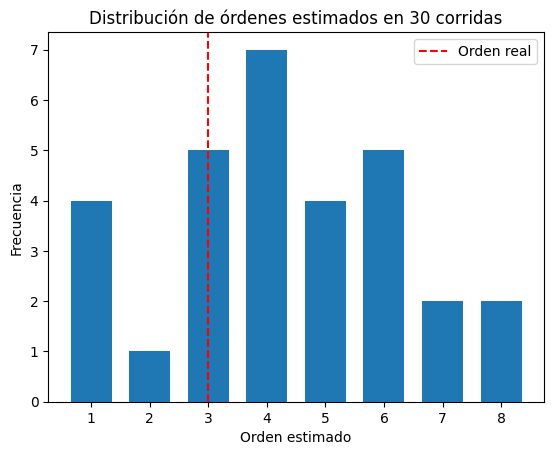

In [6]:
import matplotlib.pyplot as plt

# Parámetros de la simulación
iteraciones = 30
N = 500
orden_real = 3
varianza_ruido = 0.001
orden_max = 8
C = 5.0

ordenes_estimados = []
aciertos = 0

for _ in range(iteraciones):
    # Generar señal sintética con 'orden_real' cosenos
    x, _, _ = generar_muestra_coseno(N=N, num_cosenos=orden_real, varianza_ruido=varianza_ruido)
    
    # Estimar el orden
    orden_est, _, _ = estimador_de_orden(x, orden_max=orden_max, C=C)
    ordenes_estimados.append(orden_est)
    
    if orden_est == orden_real:
        aciertos += 1

# Resultados
print("Orden real:", orden_real)
print("Tasa de acierto:", aciertos / iteraciones)
print("Órdenes estimados:", ordenes_estimados)

# Histograma de órdenes estimados
plt.hist(ordenes_estimados, bins=range(1, orden_max+2), align="left", rwidth=0.7)
plt.axvline(orden_real, color="red", linestyle="--", label="Orden real")
plt.xlabel("Orden estimado")
plt.ylabel("Frecuencia")
plt.title(f"Distribución de órdenes estimados en {iteraciones} corridas")
plt.legend()
plt.show()


# Segundo intento del detector de orden


## Generador de muestras

Esta sección se describe los cambios y mejoras implementadas en el generador de señales cardiorespiratorias sintéticas para simulaciones con radar UWB. La función ha sido adaptada para generar señales más realistas, controlables y útiles para métodos no lineales de análisis espectral.

- Se modificaron los intervalos de frecuencia fundamentales para que reflejen rangos fisiológicos realistas para mediciones con radar UWB: la frecuencia cardíaca se estableció entre 0.6 y 1.1 Hz, lo que corresponde aproximadamente a 36 a 66 latidos por minuto, y la frecuencia respiratoria entre 0.15 y 0.35 Hz, equivalente a 9 a 21 respiraciones por minuto. Los centros de estos intervalos se utilizan como semillas para la inicialización de métodos no lineales, siendo 0.85 Hz para la cardíaca y 0.25 Hz para la respiratoria.
- Se definió que el número de componentes de cada señal corresponde al fundamental más los armónicos especificados por el usuario. Esto permite simular señales más complejas y con mayor riqueza espectral, manteniendo control sobre la cantidad de información armónica incluida.
- Los armónicos no son múltiplos exactos de la frecuencia fundamental. Se introduce un factor de dispersión aleatoria de ±5% para cada armónico, de modo que las frecuencias no sean exactos múltiplos enteros del fundamental, simulando así la inarmonicidad típica de señales fisiológicas reales.
- Las amplitudes de los componentes fueron ajustadas para reflejar la relación típica en señales UWB. La señal respiratoria es significativamente mayor que la cardíaca, con amplitudes generadas en el intervalo de 1.0 a 2.0 para respiratoria y de 0.01 a 0.1 para cardíaca, manteniendo la proporción de orden de magnitud observada en mediciones reales.
- Se mantiene la generación aleatoria de fases y offsets para cada componente dentro de rangos definidos, lo que asegura variabilidad y realismo en la forma de la señal.
- Se añadió la posibilidad de introducir ruido aditivo gaussiano con varianza especificada por el usuario. Además, la función calcula automáticamente la relación señal a ruido (SNR) resultante en decibelios, lo que permite evaluar la calidad de la señal generada en condiciones controladas.
- Los valores por defecto para la frecuencia de muestreo y la duración de la señal son 200 Hz y 30 segundos, respectivamente, parámetros adecuados para simulaciones de señales cardiorespiratorias con radar UWB.
- Se incluyen diccionarios de salida detallados: uno con los parámetros utilizados (frecuencias, amplitudes, fases, offsets, varianza y SNR), otro con los límites de cada parámetro para posibles optimizaciones, y otro con las semillas de inicialización. Además, se entrega metadata con información de la simulación, como número de componentes, frecuencia de muestreo, duración y factor de dispersión aplicado, facilitando la reutilización y análisis posterior de la señal generada.

In [1]:
import numpy as np

def generar_muestras_cardiorespiratorias(N_card=3, N_resp=2, fs=200, T=30, sigma2=0.01, epsilon=0.05, seed=None):
    """
    Generador de señales cardiorespiratorias sintéticas para radar UWB.

    Args:
        N_card (int): número de componentes de la señal cardíaca (fundamental + armónicos).
        N_resp (int): número de componentes de la señal respiratoria (fundamental + armónicos).
        fs (float): frecuencia de muestreo [Hz].
        T (float): duración de la señal [s].
        sigma2 (float): varianza del ruido aditivo gaussiano.
        epsilon (float): factor de dispersión para armónicos (±5% por defecto).
        seed (int or None): semilla para reproducibilidad.

    Returns:
        signal (np.array): señal sintetizada con ruido.
        params (dict): diccionario con parámetros de frecuencias, amplitudes, fases.
        bounds (dict): límites de cada parámetro.
        seeds (dict): centros de los intervalos para inicialización no lineal.
        metadata (dict): información de la simulación.
    """

    if seed is not None:
        np.random.seed(seed)

    t = np.arange(0, T, 1/fs)

    # Intervalos de frecuencias fundamentales
    f_card_interval = np.array([0.6, 1.1])
    f_resp_interval = np.array([0.15, 0.35])
    f_card_center = f_card_interval.mean()
    f_resp_center = f_resp_interval.mean()

    # Amplitudes
    A_card_interval = np.array([0.01, 0.1])
    A_resp_interval = np.array([1.0, 2.0])
    A_card_center = A_card_interval.mean()
    A_resp_center = A_resp_interval.mean()

    # Fases y offsets
    phase_card = np.random.uniform(0, 2*np.pi, N_card)
    phase_resp = np.random.uniform(0, 2*np.pi, N_resp)

    offset_card = np.random.uniform(-0.1,0.1)
    offset_resp = np.random.uniform(-0.1,0.1)

    # Frecuencia fundamental
    f_card0 = np.random.uniform(*f_card_interval)
    f_resp0 = np.random.uniform(*f_resp_interval)

    # Generar armónicos con dispersión
    f_card = [f_card0]
    for n in range(2, N_card+1):
        delta = np.random.uniform(-epsilon, epsilon)
        f_card.append(n*f_card0*(1+delta))

    f_resp = [f_resp0]
    for n in range(2, N_resp+1):
        delta = np.random.uniform(-epsilon, epsilon)
        f_resp.append(n*f_resp0*(1+delta))

    f_card = np.array(f_card)
    f_resp = np.array(f_resp)

    # Amplitudes para cada componente
    A_card = np.random.uniform(A_card_interval[0], A_card_interval[1], N_card)
    A_resp = np.random.uniform(A_resp_interval[0], A_resp_interval[1], N_resp)

    # Generar señal
    signal_card = np.sum([A_card[i]*np.cos(2*np.pi*f_card[i]*t + phase_card[i]) for i in range(N_card)], axis=0) + offset_card
    signal_resp = np.sum([A_resp[i]*np.cos(2*np.pi*f_resp[i]*t + phase_resp[i]) for i in range(N_resp)], axis=0) + offset_resp

    signal_clean = signal_card + signal_resp

    # Ruido y SNR
    noise = np.random.normal(0, np.sqrt(sigma2), len(t))
    signal_noisy = signal_clean + noise

    snr = 10*np.log10(np.var(signal_clean)/sigma2)

    # Preparar diccionarios de salida
    params = {
        'f_card': f_card,
        'f_resp': f_resp,
        'A_card': A_card,
        'A_resp': A_resp,
        'phase_card': phase_card,
        'phase_resp': phase_resp,
        'offset_card': offset_card,
        'offset_resp': offset_resp,
        'sigma2': sigma2,
        'SNR_dB': snr
    }

    bounds = {
        'f_card': f_card_interval,
        'f_resp': f_resp_interval,
        'A_card': A_card_interval,
        'A_resp': A_resp_interval,
        'phase': [0, 2*np.pi],
        'offset': [-0.1, 0.1]
    }

    seeds = {
        'f_card_center': f_card_center,
        'f_resp_center': f_resp_center,
        'A_card_center': A_card_center,
        'A_resp_center': A_resp_center
    }

    metadata = {
        'N_card': N_card,
        'N_resp': N_resp,
        'fs': fs,
        'T': T,
        'epsilon': epsilon
    }

    return signal_noisy, params, bounds, seeds, metadata

## Estimador de orden

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def estimar_parametros(y, t, N, rangos_freq):
    """
    Estima parámetros de una suma de N cosenos:
    y(t) = sum A_k cos(2π f_k t + φ_k)

    Estrategia:
    - No lineal: optimiza solo las frecuencias.
    - Lineal: estima amplitudes y fases para cada conjunto de frecuencias.

    Parámetros
    ----------
    y : array_like
        Señal observada (vector de tamaño M).
    t : array_like
        Vector de tiempos (tamaño M).
    N : int
        Número de cosenos a estimar.
    rangos_freq : list of tuples
        Lista [(fmin1,fmax1), (fmin2,fmax2), ...] con los rangos válidos
        para cada frecuencia.

    Retorna
    -------
    params : list of tuples
        Lista [(A1,f1,phi1), ..., (AN,fN,phiN)].
    """

    M = len(y)

    # --- Función de coste: dado un vector de frecuencias, ajusta amplitudes/fases y calcula error ---
    def coste(frecuencias):
        # Matriz de diseño con cosenos y senos
        X = []
        for f in frecuencias:
            X.append(np.cos(2*np.pi*f*t))
            X.append(np.sin(2*np.pi*f*t))
        X = np.column_stack(X)  # M x (2N)

        # Resolver mínimos cuadrados lineales
        coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        y_hat = X @ coef
        resid = y - y_hat
        return np.sum(resid**2)

    # --- Inicialización aleatoria dentro de los rangos ---
    f0 = np.array([np.random.uniform(low, high) for (low, high) in rangos_freq])

    # --- Restricciones de cada frecuencia ---
    bounds = rangos_freq

    # --- Optimización no lineal en frecuencias ---
    res = minimize(coste, f0, bounds=bounds, method="L-BFGS-B")

    f_est = res.x

    # --- Una vez obtenidas las frecuencias, estimar amplitudes y fases ---
    X = []
    for f in f_est:
        X.append(np.cos(2*np.pi*f*t))
        X.append(np.sin(2*np.pi*f*t))
    X = np.column_stack(X)

    coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

    params = []
    for k in range(N):
        a = coef[2*k]
        b = coef[2*k + 1]
        A = np.sqrt(a**2 + b**2)
        phi = np.arctan2(-b, a)
        params.append((A, f_est[k], phi))

    return params


def estimar_orden(y, t, N_max, C, rangos_freq, eps=1e-8):
    """
    Estima el orden de la señal (cantidad de cosenos) probando N=1..N_max
    con el criterio penalizado.
    """

    M = len(y)
    criterios = []

    for N in range(1, N_max+1):
        # Usamos solo los primeros N rangos
        params = estimar_parametros(y, t, N, rangos_freq[:N])

        # Reconstrucción
        y_hat = np.zeros_like(y)
        for A, f, phi in params:
            y_hat += A * np.cos(2*np.pi*f*t + phi)

        # Varianza del error
        resid = y - y_hat
        sigma2 = np.mean(resid**2)

        # Criterio penalizado (según tu pedido)
        J = M * np.log(sigma2 + eps) + C * N
        criterios.append(J)

    criterios = np.array(criterios)
    N_hat = np.argmin(criterios) + 1

    return N_hat, criterios


In [6]:

# ============================
# Configuración del experimento
# ============================
fs = 200
T = 30
sigma2 = 0.01
N_card_true = 3
N_resp_true = 2
C = 10        # constante de penalización
N_max = 8     # orden máximo a probar

# ============================
# 1. Generar señal sintética
# ============================
signal_noisy, params_true, bounds, seeds, metadata = generar_muestras_cardiorespiratorias(
    N_card=N_card_true,
    N_resp=N_resp_true,
    fs=fs,
    T=T,
    sigma2=sigma2,
    seed=42
)

t = np.arange(0, T, 1/fs)

# ============================
# 2. Estimar parámetros para orden verdadero
# ============================
# Aquí se asume que ya tenés `estimar_parametros` definida
N_true = N_card_true + N_resp_true
rangos_freq = [bounds['f_card']] * N_card_true + [bounds['f_resp']] * N_resp_true

params_est = estimar_parametros(signal_noisy, t, N_true, rangos_freq)

# ============================
# 3. Estimar orden
# ============================
N_hat, criterios = estimar_orden(signal_noisy, t, N_max=N_max, C=C, rangos_freq=rangos_freq)

# ============================
# 4. Reconstrucción de la señal
# ============================
y_hat = np.zeros_like(signal_noisy)
for A, f, phi in params_est:
    y_hat += A * np.cos(2*np.pi*f*t + phi)

# ============================
# 5. Gráficos
# ============================
plt.figure(figsize=(12,5))
plt.plot(t, signal_noisy, label="Señal observada", alpha=0.7)
plt.plot(t, y_hat, label=f"Reconstrucción (N={N_true})", linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.title("Señal sintética vs Reconstrucción")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(criterios)+1), criterios, marker="o")
plt.axvline(N_hat, color="r", linestyle="--", label=f"Orden estimado = {N_hat}")
plt.xlabel("Orden N")
plt.ylabel("Criterio penalizado")
plt.title("Selección de orden")
plt.legend()
plt.show()

# ============================
# 6. Resultados
# ============================
print("Parámetros verdaderos:")
for i, (A,f,phi) in enumerate(zip(
        np.concatenate([params_true['A_card'], params_true['A_resp']]),
        np.concatenate([params_true['f_card'], params_true['f_resp']]),
        np.concatenate([params_true['phase_card'], params_true['phase_resp']])
    )):
    print(f"Componente {i+1}: A={A:.3f}, f={f:.3f}, phi={phi:.3f}")

print("\nParámetros estimados:")
for i, (A,f,phi) in enumerate(params_est):
    print(f"Componente {i+1}: A={A:.3f}, f={f:.3f}, phi={phi:.3f}")

print(f"\nOrden verdadero: {N_true}")
print(f"Orden estimado : {N_hat}")

IndexError: index 10 is out of bounds for axis 0 with size 10